In [116]:
from pathlib import Path
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import display
from collections import OrderedDict

In [2]:
df_train = pd.read_pickle('my_df_train.pickle')
df_test = pd.read_pickle('my_df_test.pickle')


In [26]:
df_test

,lat,lon,year_month,inj_vol,pp,lambda
0,96.8,36.4,2017.83,"[0.24230300000000002, 0.364577, 0.69597, 0.760...","[5.260705, 5.240016000000001, 11.603881, 10.67...",0.255919
1,96.8,36.4,2017.92,"[0.364577, 0.69597, 0.7606510000000001, 0.8123...","[5.240016000000001, 11.603881, 10.673083, 12.5...",0.255919
2,96.8,36.4,2018.00,"[0.69597, 0.7606510000000001, 0.812368, 0.8489...","[11.603881, 10.673083, 12.5484706, 9.9422368, ...",0.255919
3,96.8,36.4,2018.08,"[0.7606510000000001, 0.812368, 0.8489909999999...","[10.673083, 12.5484706, 9.9422368, 14.05150280...",0.255919
4,96.8,36.4,2018.17,"[0.812368, 0.8489909999999999, 0.793254, 0.850...","[12.5484706, 9.9422368, 14.051502800000002, 13...",0.255919
...,...,...,...,...,...,...
14,96.8,35.4,2018.33,"[2.56893, 2.43225, 2.54391, 2.66482, 2.3774599...","[14.80995, 15.22363, 15.03058, 16.80253, 15.88...",0.080100
15,96.8,35.4,2018.42,"[2.43225, 2.54391, 2.66482, 2.3774599999999997...","[15.22363, 15.03058, 16.80253, 15.885525999999...",0.080100
16,96.8,35.4,2018.50,"[2.54391, 2.66482, 2.3774599999999997, 2.60024...","[15.03058, 16.80253, 15.885525999999999, 16.25...",0.080100
17,96.8,35.4,2018.58,"[2.66482, 2.3774599999999997, 2.60024000000000...","[16.80253, 15.885525999999999, 16.25784, 12.70...",0.080100


In [4]:
# train
inj_vol = np.stack(df_train['inj_vol'].values)
pp = np.stack(df_train['pp'].values)

# dim: 2814 x 24
x_train = np.hstack([inj_vol, pp])
y_train = df_train['lambda'].values

# test
inj_vol = np.stack(df_test['inj_vol'].values)
pp = np.stack(df_test['pp'].values)

# dim: _ x 24
x_test = np.hstack([inj_vol, pp])
y_test = df_test['lambda'].values

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(2814, 24) (2814,)
(809, 24) (809,)


In [5]:
import torch 
from torch import nn

class Feedforward(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        # create layers
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_size, 1)
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        return output

In [6]:
# convert train test data to torch tensors
X_train = torch.from_numpy(x_train.astype('float32'))
Y_train = torch.from_numpy(np.expand_dims(y_train, axis=-1).astype('float32'))
X_test = torch.from_numpy(x_test.astype('float32'))
Y_test = torch.from_numpy(np.expand_dims(y_test, axis=-1).astype('float32'))

In [7]:
print(X_train.shape, Y_train.shape, X_train.dtype, Y_train.dtype)
print(X_test.shape, Y_test.shape, X_test.dtype, Y_test.dtype)


torch.Size([2814, 24]) torch.Size([2814, 1]) torch.float32 torch.float32
torch.Size([809, 24]) torch.Size([809, 1]) torch.float32 torch.float32


In [23]:
model = Feedforward(24, 32)
loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)


In [24]:
model.train()
loss_train_array = []
loss_test_array = []
epoch = 20000
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    loss_train = loss_fn(model(X_train), Y_train)
    loss_train_array.append(loss_train)
    loss_test = loss_fn(model(X_test), Y_test)
    loss_test_array.append(loss_test)

   
    print('Epoch %s: train loss: %6.4f, test loss %6.4f'%(epoch, loss_train.item(), loss_test.item()))
    # Backward pass
    loss_train.backward()
    optimizer.step()




Epoch 0: train loss: 1.2543, test loss 6.6307
Epoch 1: train loss: 1.1132, test loss 6.6091
Epoch 2: train loss: 1.0013, test loss 6.6097
Epoch 3: train loss: 0.9124, test loss 6.6249
Epoch 4: train loss: 0.8410, test loss 6.6496
Epoch 5: train loss: 0.7837, test loss 6.6789
Epoch 6: train loss: 0.7379, test loss 6.7100
Epoch 7: train loss: 0.7010, test loss 6.7416
Epoch 8: train loss: 0.6712, test loss 6.7722
Epoch 9: train loss: 0.6468, test loss 6.8013
Epoch 10: train loss: 0.6269, test loss 6.8280
Epoch 11: train loss: 0.6105, test loss 6.8517
Epoch 12: train loss: 0.5969, test loss 6.8722
Epoch 13: train loss: 0.5855, test loss 6.8894
Epoch 14: train loss: 0.5759, test loss 6.9034
Epoch 15: train loss: 0.5678, test loss 6.9143
Epoch 16: train loss: 0.5608, test loss 6.9222
Epoch 17: train loss: 0.5547, test loss 6.9275
Epoch 18: train loss: 0.5493, test loss 6.9303
Epoch 19: train loss: 0.5445, test loss 6.9307
Epoch 20: train loss: 0.5401, test loss 6.9290
Epoch 21: train loss: 0

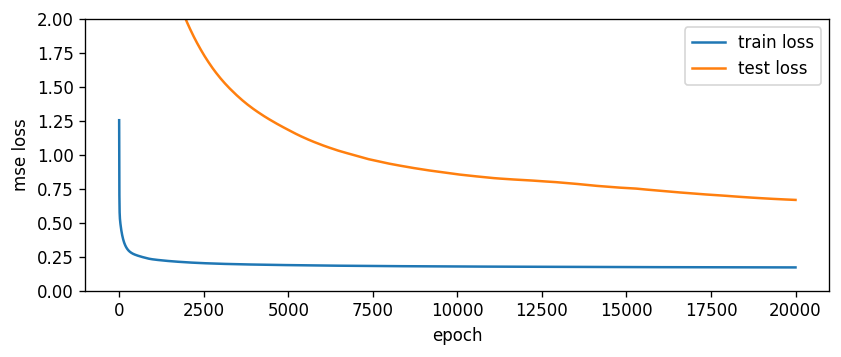

In [115]:
plt.figure(figsize=(8,3), dpi=120)
plt.plot(loss_train_array)
plt.plot(loss_test_array)
plt.legend(['train loss', 'test loss'])
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.ylim([0,2])
plt.show()

# Training and testing for each cordinate

In [30]:
model.eval()
X_pred = model(X_test)



In [33]:
df_test['Pred'] = X_pred.detach().numpy()

In [85]:

loss_co_ord = OrderedDict()
for co_ord, df_c in df_test.groupby(['lat','lon']):
    loss = (df_c['Pred'] - df_c['lambda'])**2
    loss_co_ord[str(co_ord)] = loss
    # loss_co_ord.append(loss.detach().item())

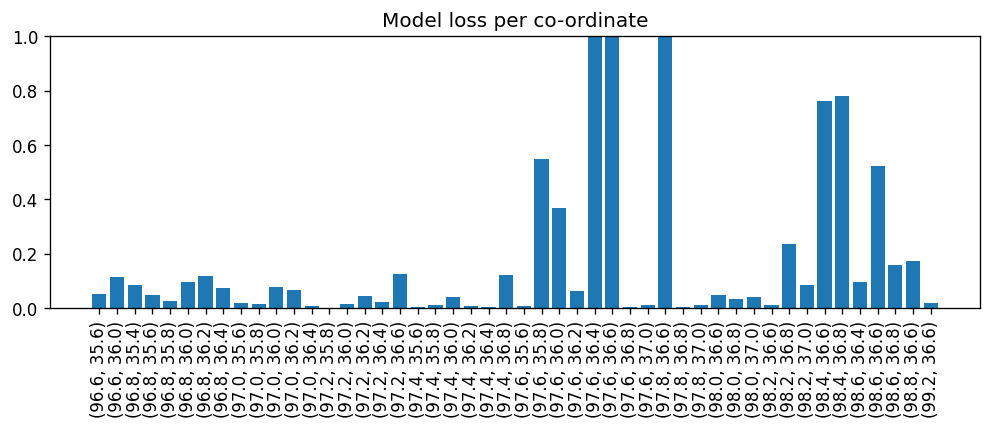

In [106]:
plt.figure(figsize=(10,3), dpi=120)
plt.bar(loss_co_ord.keys(), [x.mean() for x in loss_co_ord.values()])
# notch shape box plot
# plt.boxplot(loss_co_ord.values(),
#                      notch=True,  # notch shape
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=loss_co_ord.keys())  # will be used to label x-ticks
plt.ylim([0,1])
plt.xticks(rotation=90)
plt.title('Model loss per co-ordinate')
plt.show()